In [1]:
# TensorFlow is used for building the model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# For data handling
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
# Normalize the images to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5


4422102/4422102 [==============================] - 0s 0us/step


In [3]:
def build_generator():
    model = Sequential([
        Dense(128, input_dim=100),
        LeakyReLU(alpha=0.01),
        Dense(784, activation='tanh'),
        Reshape((28, 28, 1))
    ])
    return model
generator = build_generator()


In [4]:
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dense(1, activation='sigmoid')
    ])
    return model
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


In [5]:
def build_gan(generator, discriminator):
    model = Sequential([generator, discriminator])
    return model

# Compile the GAN
discriminator.trainable = False  # Only train generator within the GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [8]:
def train(gan, generator, discriminator, dataset, epochs, batch_size, noise_dim, save_interval):
    d_losses, g_losses = [], []
    for epoch in range(epochs):
        for _ in range(dataset.shape[0] // batch_size):
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gen_imgs = generator.predict(noise)
            real_imgs = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

            d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

            d_losses.append(d_loss[0])
            g_losses.append(g_loss)

        if (epoch + 1) % save_interval == 0:
            save_images(epoch + 1, generator, noise_dim)

        print(f"Epoch: {epoch+1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

    return d_losses, g_losses

def save_images(epoch, generator, noise_dim, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    plt.close()



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step
Epoch: 90, D Loss: 0.5582597255706787, G Loss: 1.3155090808868408
4/4 [==============================] - 0s 5ms/step
Epoch: 91, D Loss: 0.6005325615406036, G Loss: 1.274491548538208
4/4 [==============================] - 0s 6ms/step
Epoch: 92, D Loss: 0.587437242269516, G Loss: 1.3603484630584717
4/4 [==============================] - 0s 4ms/step
Epoch: 93, D Loss: 0.6086696982383728, G Loss: 1.3437587022781372
4/4 [==============================] - 0s 6ms/step
Epoch: 94, D Loss: 0.5874757766723633, G Loss: 1.2797019481658936
4/4 [==============================] - 0s 6ms/step
Epoch: 95, D Loss: 0.6099455952644348, G Loss: 1.1661405563354492
4/4 [==============================] - 0s 5ms/step
Epoch: 96, D Loss: 0.6078215837478638, G Loss: 1.257208228111267
4/4 [==============================] - 0s 5ms/step
Epoch: 97, D Loss: 0.5750875473022461, G Loss: 1.2388677597045898
4/4 [==========

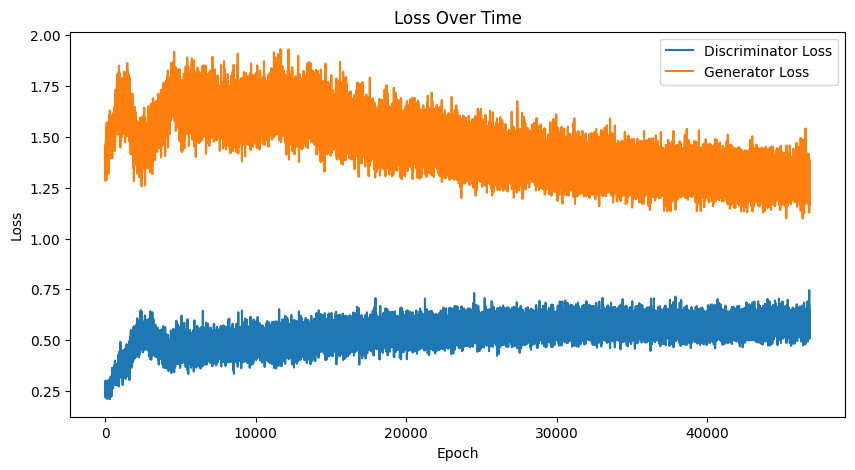

In [10]:
d_losses, g_losses = train(gan, generator, discriminator, train_images, epochs=100, batch_size=128, noise_dim=100, save_interval=10)

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Discriminator and Generator Dynamics: Initially, the discriminator's loss decreases, indicating that it's successfully learning to distinguish real images from fake ones. However, as training progresses, it appears that the generator begins to improve, making it harder for the discriminator to differentiate, which is typical in GAN training.

Convergence: The generator's loss decreases and then stabilizes, suggesting that the generator is improving at creating believable images as perceived by the discriminator. However, the slight fluctuations might indicate areas where the generator still struggles.

Balance Between Generator and Discriminator: It's important for a well-functioning GAN that neither the generator nor the discriminator becomes too good too quickly. Your graph shows that the losses stabilize, which is a good sign of balance.

Interpretation of Fluctuations: The fluctuations especially in the generator loss might be worth discussing. It could indicate points where the generator found and then lost (temporarily) effective strategies for fooling the discriminator.